In [1]:
!pip install -U keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.7 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 8.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0


In [2]:
!pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import csv
import os
from keras.models import Sequential, Model
from keras.layers import Dense,Activation, Input,SimpleRNN,Embedding,Dropout,GlobalMaxPooling1D,MaxPooling1D,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets.public_api as tfds
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Obs: Otimização de hiperparametros

In [4]:
ds_train = tfds.load('snli', split='train[:50%]', shuffle_files=True)
ds_valid = tfds.load('snli', split='validation', shuffle_files=False)
ds_test = tfds.load('snli', split='test', shuffle_files=False)
ds_train

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incompleteVLL3O3/snli-test.tfrecord*...:   0%|          | 0/10000 […

Generating validation examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incompleteVLL3O3/snli-validation.tfrecord*...:   0%|          | 0/1…

Generating train examples...:   0%|          | 0/550152 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incompleteVLL3O3/snli-train.tfrecord*...:   0%|          | 0/550152…

Dataset snli downloaded and prepared to ~/tensorflow_datasets/snli/1.1.0. Subsequent calls will reuse this data.


<PrefetchDataset element_spec={'hypothesis': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'premise': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [5]:
df_train = tfds.as_dataframe(ds_train)
df_valid = tfds.as_dataframe(ds_valid)
df_test = tfds.as_dataframe(ds_test)

In [6]:
df_test.head()

,hypothesis,label,premise
0,b'A girl is entertaining on stage',0,b'A girl in a blue leotard hula hoops on a sta...
1,b'A group of people posing in front of a body ...,0,b'A group of people taking pictures on a walkw...
2,"b""The group of people aren't inide of the buil...",0,b'Many people standing outside of a place talk...
3,b'The people are taking a carriage ride.',0,b'Three people are riding a carriage pulled by...
4,b'Two girls are getting ready to ride horses.',1,b'Two girls feeding a horse an apple.'


In [7]:
df_train['hypothesis'] = [x.decode('utf-8') for x in df_train['hypothesis']] 
df_train['premise'] = [x.decode('utf-8') for x in df_train['premise']] 

df_valid['hypothesis'] = [x.decode('utf-8') for x in df_valid['hypothesis']] 
df_valid['premise'] = [x.decode('utf-8') for x in df_valid['premise']] 

df_test['hypothesis'] = [x.decode('utf-8') for x in df_test['hypothesis']] 
df_test['premise'] = [x.decode('utf-8') for x in df_test['premise']] 

In [8]:
df_test.head()

,hypothesis,label,premise
0,A girl is entertaining on stage,0,A girl in a blue leotard hula hoops on a stage...
1,A group of people posing in front of a body of...,0,A group of people taking pictures on a walkway...
2,The group of people aren't inide of the building.,0,Many people standing outside of a place talkin...
3,The people are taking a carriage ride.,0,Three people are riding a carriage pulled by f...
4,Two girls are getting ready to ride horses.,1,Two girls feeding a horse an apple.


In [9]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_valid['label'] = pd.Categorical(df_valid['label'])
y_valid_int = df_valid['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

In [10]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

In [11]:
train_tweets = df_train['premise'].to_list() + df_train['hypothesis'].to_list()

vocabulary = {}

for i in range(0,len(train_tweets)):
    train_tweets[i] = train_tweets[i].lower()
    for word in train_tweets[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

In [12]:
vocab_size = len(vocabulary)

In [16]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train['hypothesis'] + df_train['premise'])

In [18]:
train_sequences = tokenizer.texts_to_sequences(df_train['hypothesis'] + df_train['premise'])

Pós-processamento da numericalização

In [32]:
max_words = 105

hist = {}

hist['qtde'] = [x for x in range(0,max_words)]

lista = [0]*(max_words)
for x in train_sequences:
    lista[len(x)]+=1

hist['num tweets'] = lista

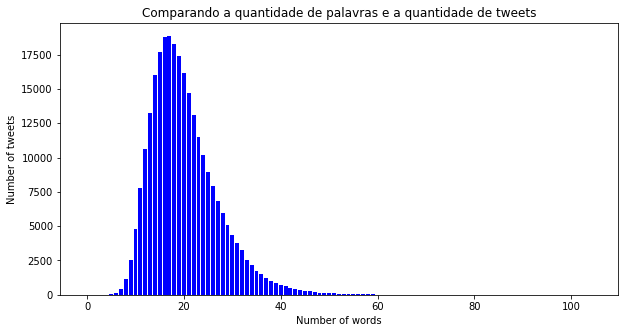

In [33]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(hist['qtde'],hist['num tweets'],
        color ='blue')
 
plt.xlabel("Number of words")
plt.ylabel("Number of tweets")
plt.title("Comparando a quantidade de palavras e a quantidade de tweets")
plt.show()

In [34]:
max_length = 60

In [35]:
trunc_type = 'post'
padding_type = 'post'
train_padded = pad_sequences(train_sequences, maxlen=2000, padding=padding_type, truncating=trunc_type)

In [36]:
valid_sequences = tokenizer.texts_to_sequences(df_valid['hypothesis'] + df_valid['premise'])
test_sequences = tokenizer.texts_to_sequences(df_test['hypothesis'] + df_test['premise'])

valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [37]:
model = Sequential()
model.add(Embedding(2000, output_dim = 64))
model.add(SimpleRNN(128,return_sequences=True,activation='relu'))
model.add(Dropout(0.5))
model.add(SimpleRNN(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          128000    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 128)         24704     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 165,251
Trainable params: 165,251
Non-trai

In [38]:
input1 = Input(shape=(3,1))
rnn_output = SimpleRNN(1,return_sequences= True, activation='relu')(input1)
model = Model(inputs=input1, outputs=rnn_output)

t = [0.4,0.6,0.3]
p = model.predict(array(t).reshape(1,3,1))
print(p)
#modelo_customizado.summary()

NameError: ignored

In [ ]:
sgd = SGD(learning_rate=0.01)
modelo_customizado.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = modelo_customizado.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),epochs=30)

In [ ]:
#Keras Tuner
#!pip install keras-tuner --upgrade

In [ ]:
from numpy import array
from keras.models import Model

input1 = Input(shape=(1,2))
rnn_output = SimpleRNN(2,activation='relu')(input1)
predictions = Activation('softmax')(rnn_output)
modelo_customizado = Model(inputs=input1, outputs=predictions)